# **Feature Engineering**

## Objectives

* Engineer features for classification model

## Inputs

* The Productivity_with_AI.csv file in 'outputs/datasets/collection/'

## Outputs

* Generate a list with variables to engineer

## Additional Comments

* No additional comments.


---

# Change working directory

The notebooks are stored in a subfolder. Therefore when running the notebook in the editor, you will need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Portfolio-Project-5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Portfolio-Project-5'

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(10)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.35,473,5,9.1,1,0,1.14,1.5,1
1,3.35,412,4,7.1,0,2,1.71,4.3,0
2,8.08,600,2,7.8,8,1,0.58,2.3,1
3,8.29,600,3,6.9,3,3,3.55,5.2,1
4,8.16,600,1,8.3,6,0,0.30,2.2,1
5,1.93,206,5,4.1,4,2,1.15,7.0,0
6,9.93,600,2,8.6,10,1,3.14,1.9,1
7,0.95,108,7,6.9,3,0,0.39,6.2,0
8,6.26,600,7,9.1,6,0,0.50,4.4,1
9,3.57,360,3,7.8,5,1,1.25,4.4,0


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(10)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.19,523,3,7.1,7,0,1.78,6.2,1
1,1.96,149,5,9.2,0,0,1.24,2.7,0
2,2.52,283,6,7.7,0,0,0.35,4.4,0
3,6.34,580,5,5.5,3,2,1.53,6.3,1
4,5.07,574,7,8.8,4,0,1.15,5.8,1
5,3.88,425,3,5.2,6,0,0.57,5.1,0
6,6.36,600,2,4.7,7,1,2.22,6.9,1
7,6.76,600,4,7.8,5,0,2.88,5.2,1
8,6.31,600,1,5.3,4,1,1.38,5.4,1
9,5.46,491,7,7.7,11,1,1.16,6.5,1


---

# Data Exploration

Note which variables might profit from a transformation.

In [6]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation and PPS Analysis

No changes were made. Therefore the outcome is the same as in the DataCleaning notebook.

# Feature Engineering

## Custom Function

In [7]:
%matplotlib inline

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Feature Engineering Summary

* Numerical Transformation on 'coffee_intake_mg', 'bugs_reported', 'ai_usage_hours'
* Smart Correlation Selection on all variables

### Numerical Transformation

In [9]:
variables_engineering = ['coffee_intake_mg', 'bugs_reported', 'ai_usage_hours']
variables_engineering

['coffee_intake_mg', 'bugs_reported', 'ai_usage_hours']

In [10]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,coffee_intake_mg,bugs_reported,ai_usage_hours
0,473,0,1.14
1,412,2,1.71
2,600,1,0.58


* Variable Analyzed: coffee_intake_mg
* Applied transformation: ['coffee_intake_mg_log_e', 'coffee_intake_mg_log_10', 'coffee_intake_mg_reciprocal', 'coffee_intake_mg_power', 'coffee_intake_mg_box_cox', 'coffee_intake_mg_yeo_johnson'] 



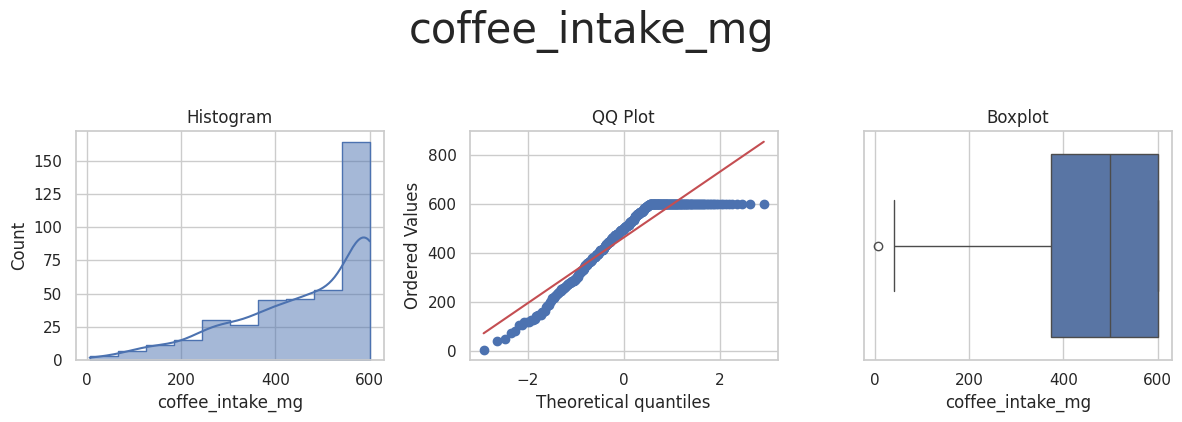

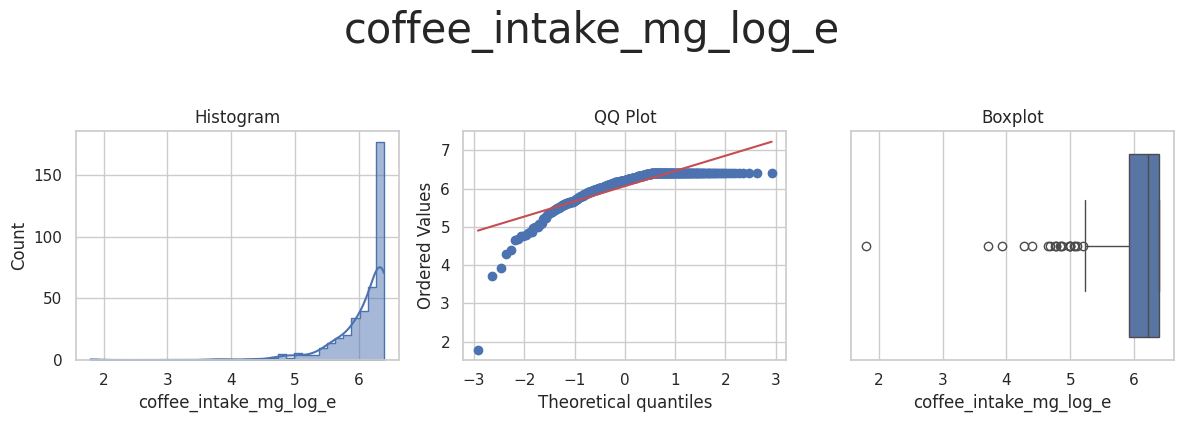

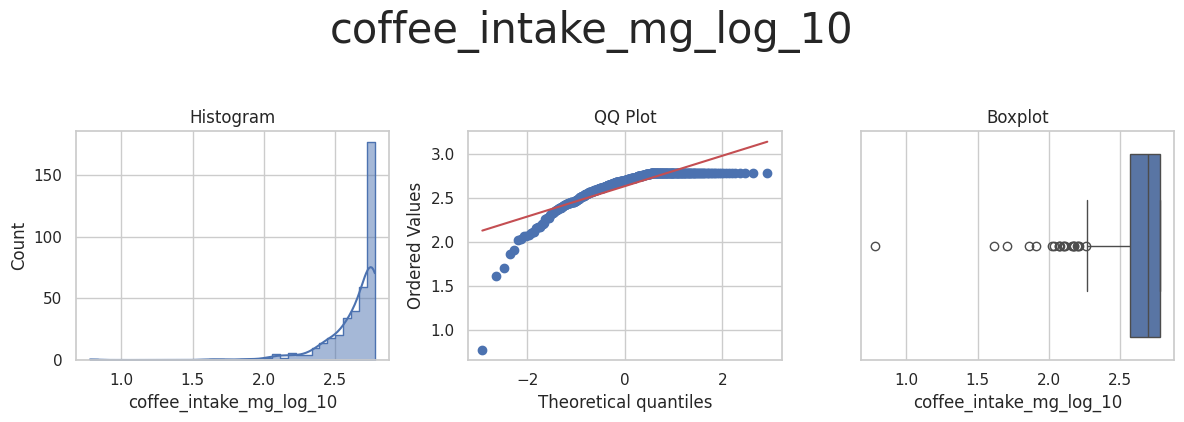

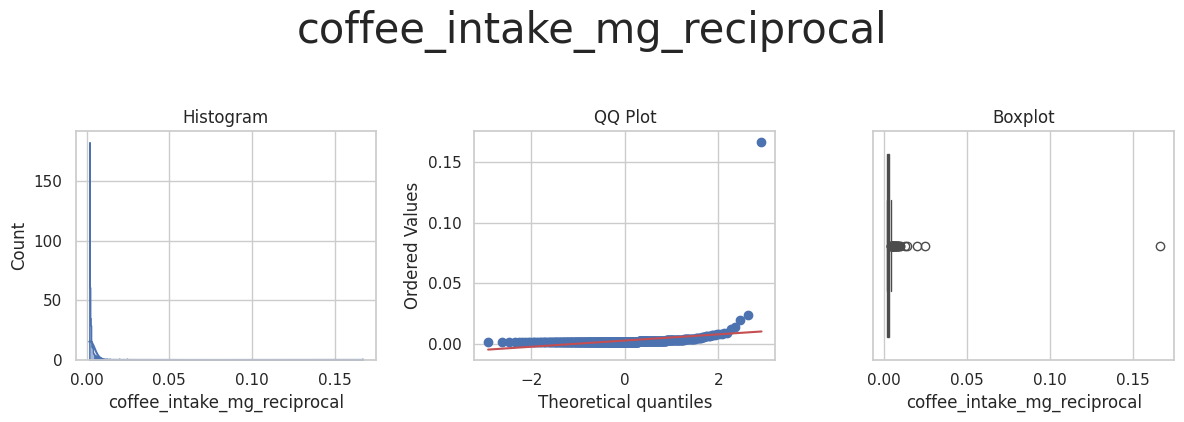

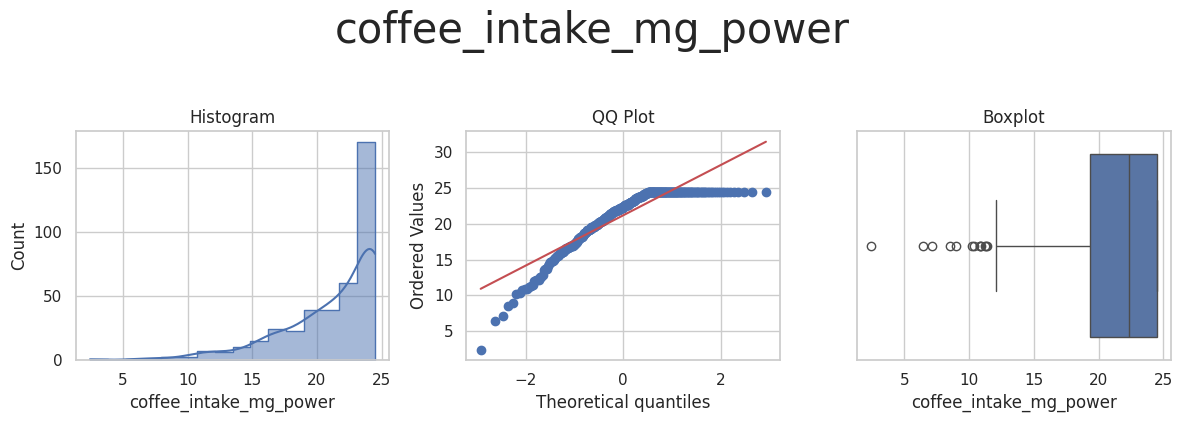

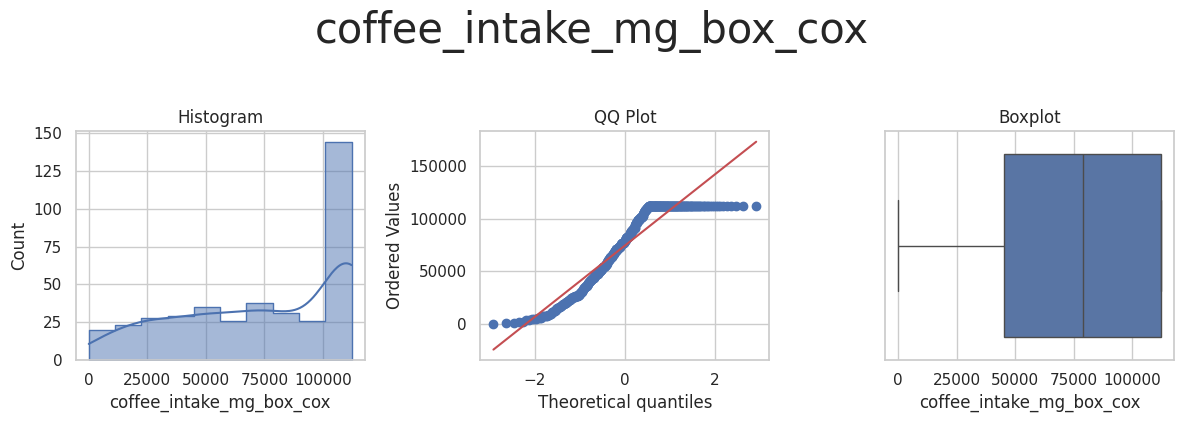

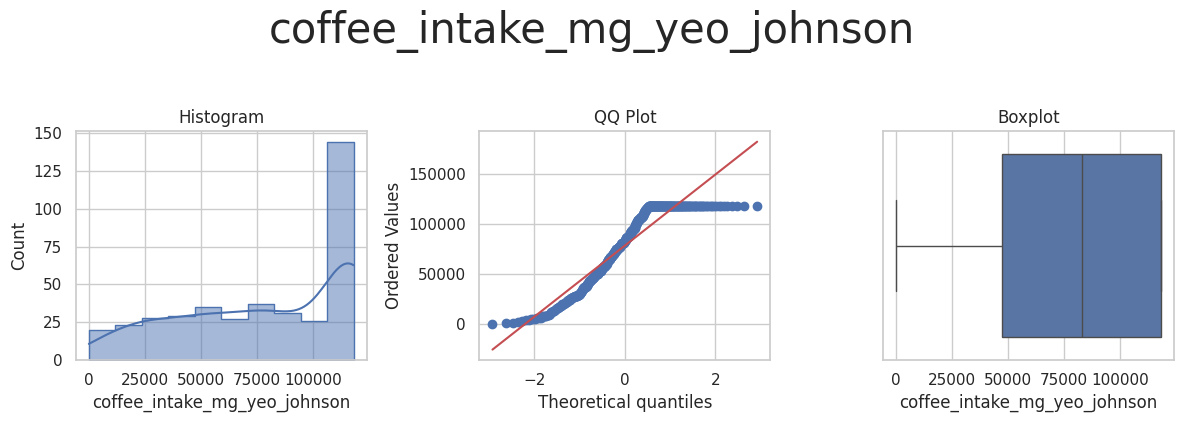



* Variable Analyzed: bugs_reported
* Applied transformation: ['bugs_reported_power', 'bugs_reported_yeo_johnson'] 



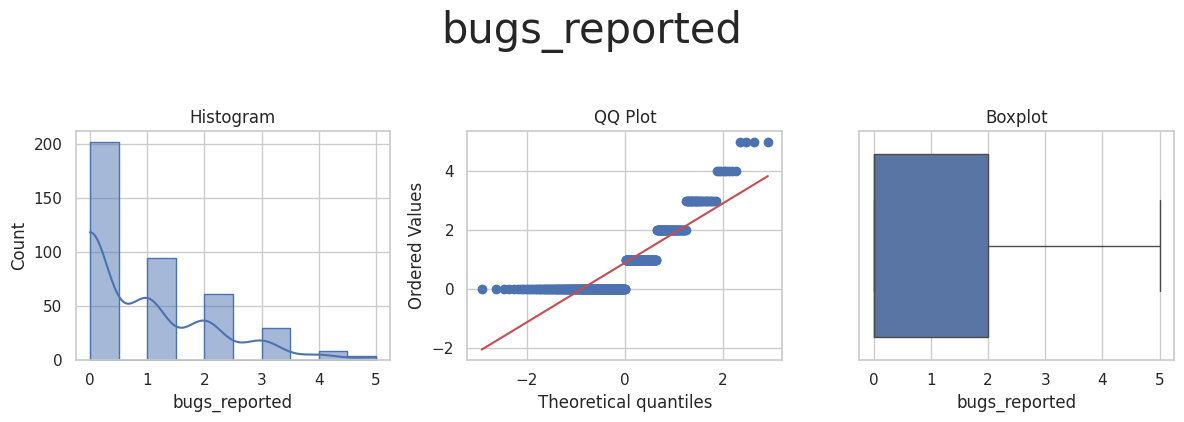

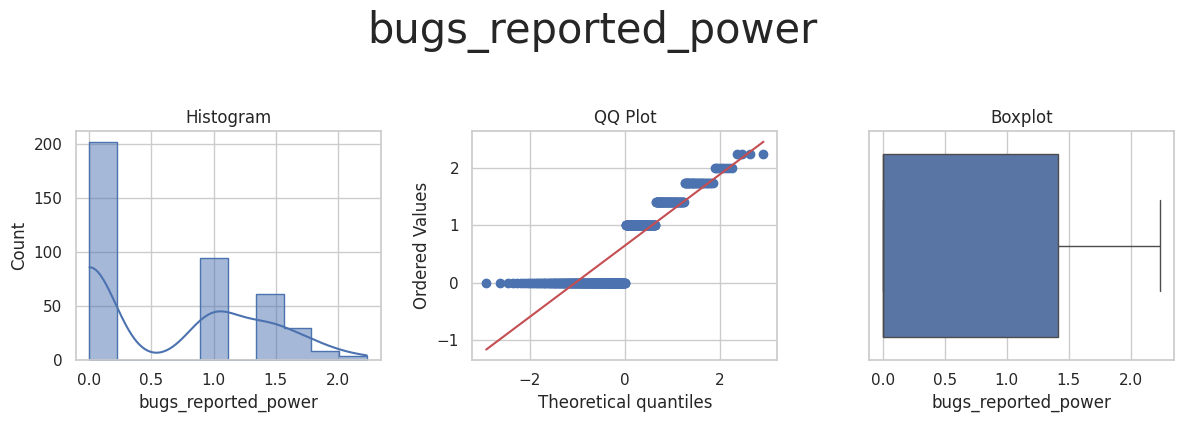

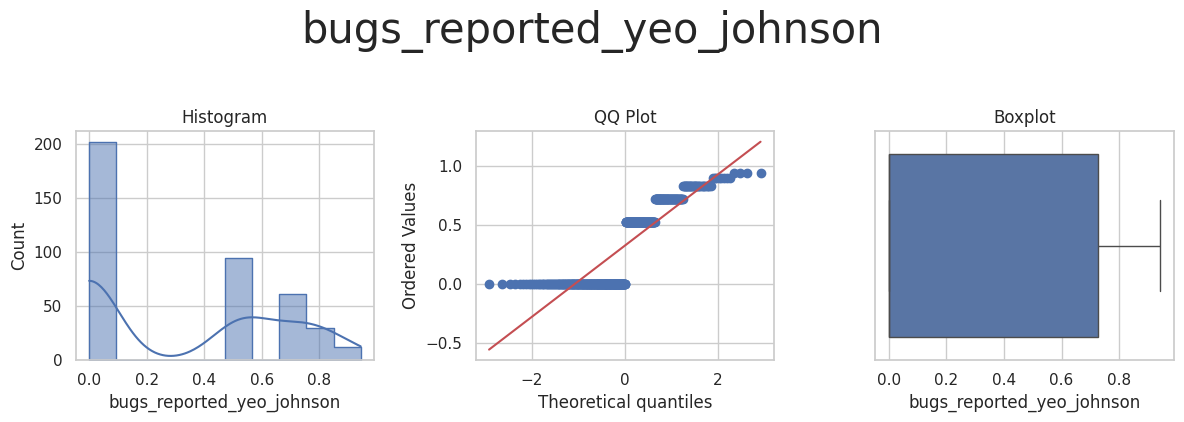



* Variable Analyzed: ai_usage_hours
* Applied transformation: ['ai_usage_hours_power', 'ai_usage_hours_yeo_johnson'] 



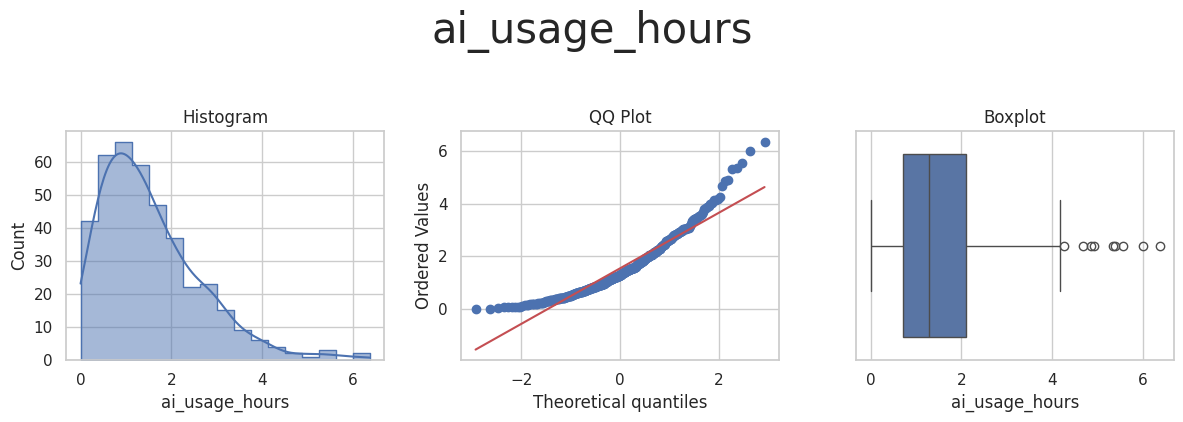

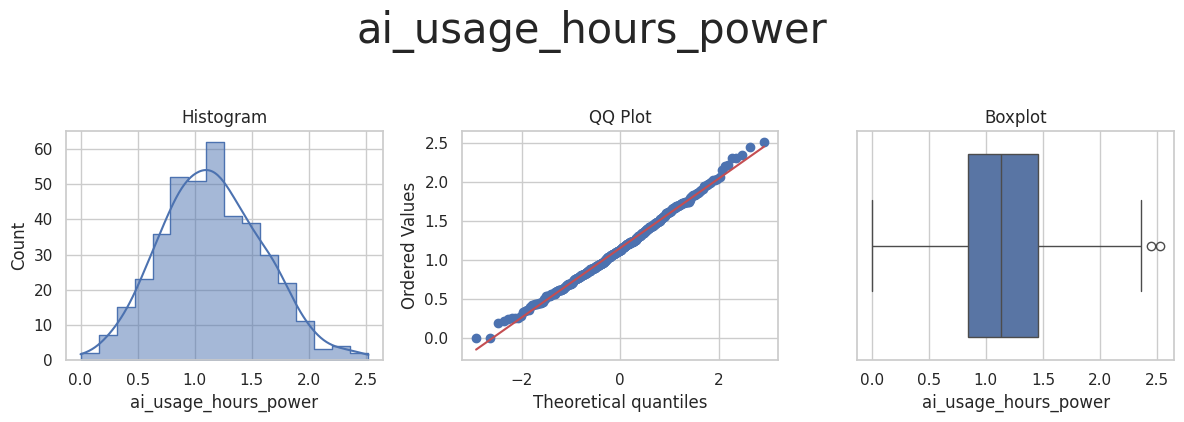

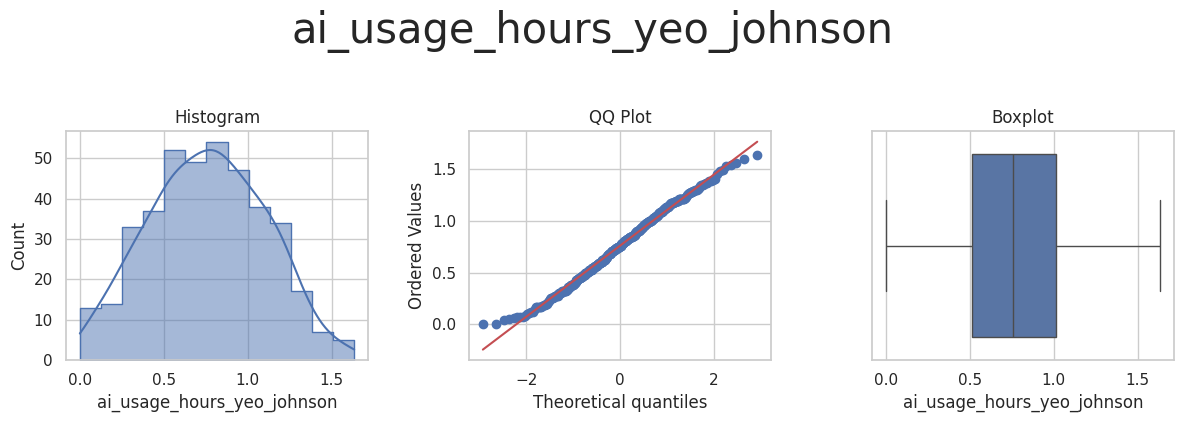

In [11]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

### SmartCorrelatedSelection Variables

In [12]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.35,473,5,9.1,1,0,1.14,1.5,1
1,3.35,412,4,7.1,0,2,1.71,4.3,0
2,8.08,600,2,7.8,8,1,0.58,2.3,1


In [13]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'coffee_intake_mg', 'commits', 'hours_coding', 'task_success'},
 {'cognitive_load', 'sleep_hours'}]

In [14]:
corr_sel.features_to_drop_

['hours_coding', 'sleep_hours', 'commits', 'task_success']

---

# Conclusion

* Numerical transformation was tested on 'coffee_intake_mg', 'bugs_reported' and 'ai_usage_hours', since those had no normal distribution. However, with the exception of 'ai_usage_hours' there was no significant improvement on the variable's distributions.

* Smart Correlation Selection was used on all variables leading to 'hours_coding', 'sleep_hours', 'commits' and 'task_success' being dropped.

## Summary

These steps will be added to the pipeline:

* Feature Engineering:
  * Numerical transformation using the PowerTransformer: ['ai_usage_hours']
  * Smart Correlation Selection: all variables